# Gene_reads.py

## Introduction
To get an indication of possible essential genes, the number of transposon insertions and amount of reads per transposon is plotted along the length of the gene. If a gene consists of a large area without any insertions or with little reads, this might indicate an essential (region of a) gene.
However, it sometimes might happen that non-essential genes have no transposons. This can mulitple reasons, most notable which are:
- Sequencing reads that map to repeated sequences were discarded during alignment. If these repeated sequences occur in protein coding regions in the genome, then these regions might be removed during alignment and therefore these genes appear to be free of transposon, even though these genes might not be essential.
- Annotated dubious ORFs might overlap with essential genes. So the dubious ORFs are not essential, but have no insertions because of the overlap.
- Sometimes genes might not be essential in normal growth conditions (and hence are not annotated as such), but in particular lab conditions some genes can become essential (for example genes involved in the metabolism of certain sugars).

Also, sometimes transposons occur in essential genes. This can be because not the complete gene is essential, but only certain domains of the gene are essential. The non-essential domain can be truncated and still create a function protein with only the essential domains left. Also, sometimes the first and/or last few basepairs can be truncated while still leave a gene that can be transcribed and translated in a functional protein.

For a more thorough discussion, see the paper from Michel et.al. 2017.

## The python script
This function creates a bar plot with the number of reads per transposon for regions in a gene. It also shows the exact locations of the insertions along the gene. The width of the bars are chosen such that each bar include a fixed amount of transposons. A maximum threshold is set to account for the situation where there are little or no transposons present for large portion of the gene.

Next to the bar plot, this function also creates a violin plot where a distribution is shown for the distance (in terms of basepairs) between subsequent insertions. This is compared with the distance between insertions in the entire chromosome the gene is in. If the median distance between insertions is significantly higher in the gene compared to the chromosome, then this might be an indication of an essential gene.

### Input
The function inputs either a gene name (`gene_name`, type=string) or a region (`region`, type=list) specified as a list with three entries (chromosome number as a roman numeral, start position of the region and the end position respectively).
The variable `gene_name` can be set to any gene name or `holocus` or `ho-locus`.
Next it requires the bed-file (`bed_file`, type=string) which is created by the Matlab code provided from the Kornman lab [https://sites.google.com/site/satayusers/complete-protocol/bioinformatics-analysis/matlab-script].
Finally, the figure can be automatically saved (at a location specified in the beginning of the function) by setting `savefigure` to `True`.

The custom build functions (stored in the 'python modules' folder on Github [https://github.com/Gregory94/LaanLab-SATAY-DataAnalysis/tree/master/python_modules]) that are required are:
- chromosome_and_gene_positions.gene_position
- gene_names.gene_aliases
- chromosome_names_in_files.chromosome_props_bedfile
- statistics_perchromosome

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb

# file_dirname = os.path.dirname(os.path.abspath('__file__'))
file_dirname = os.path.dirname('__file__')
sys.path.insert(1,os.path.join(file_dirname,'python_modules'))
os.chdir('mini_book/docs/Python_scripts/python_modules/')
from chromosome_and_gene_positions import gene_position
from gene_names import gene_aliases
from chromosome_names_in_files import chromosome_name_bedfile
import statistics_perchromosome


#FUNCTION INPUTS
gene_name = 'bem1'
region=None
# bed_file = "satay_analysis_testdata/Output_Processing/Cerevisiae_WT2_Michel2017_trimmed1.bam.bed"
# abs_bed_file = os.path.join(file_dirname, bed_file)
bed_file = os.path.join(file_dirname,'..','satay_analysis_testdata','Output_Processing','Cerevisiae_WT2_Michel2017_trimmed1.bam.bed')#CHANGE THIS TO ANY .BED FILE YOU WANT TO ANALYSE.
print(os.path.exists(os.path.join(file_dirname,'..','satay_analysis_testdata','Output_Processing')))
savefigure=False

False


### Loading files
Next additional files are loaded. Change these to your local paths leading to the gff-file (for example downloaded from SGD [https://www.yeastgenome.org/] or get a copy from the docs folder on Github [https://github.com/Gregory94/LaanLab-SATAY-DataAnalysis]) and yeast_protein_Names file.
The `save_figure_path` directs to the location where the figures need to be stored.

In [2]:
os.chdir('../')
gff_file = 'Data_Files/Saccharomyces_cerevisiae.R64-1-1.99.gff3'
abs_gff_file = os.path.join(file_dirname, gff_file)
# gff_file = os.path.join(file_dirname,'Data_Files','Saccharomyces_cerevisiae.R64-1-1.99.gff3')
gene_information_file = os.path.join(file_dirname,'Data_Files','Yeast_Protein_Names.txt')


if savefigure == True:
    save_figure_path = file_dirname

### Get start and end position of the gene or region
When a gene name is given, this part searches in the .gff file for the position and reading orientation of the gene.
However, often genes have multiple names and the name given by the user might be present as such in the .gff file.
Therefore this code searches for potential aliases of the gene name in the Yeast_Protein_Names.txt file.

In [3]:
if gene_name.upper() == 'HOLOCUS' or gene_name == 'HO-LOCUS':
    gene_pos = ['IV',46271,48031]
    gene_name = 'HOlocus'

elif gene_name != None:
    gene_pos_dict = gene_position(gff_file) #GET POSITION INFORMATION OF ALL GENES
    
    gene_name = gene_name.upper() #CAPITALIZE GENE NAME
    if gene_pos_dict.get(gene_name) == None: #CHECK IF GENE_NAME EXISTS IN GENE_POS_DICT. IF NOT, CHECK IF ANY OF THE ALIASES EXISTS
        gene_alias_dict = gene_aliases(gene_information_file)[0]
        gene_alias_key = [k for k, v in gene_alias_dict.items() if gene_name in v]
        if gene_pos_dict.get(gene_alias_key[0]) == None: #IF KEY DOES ALSO NOT EXISTS IN GENE_POS_DICT, CHECK IF MORE ALIASES EXISTS OF GENE_NAME
            gene_alias_list = gene_alias_dict.get(gene_alias_key[0])
            for gene_alias in gene_alias_list:
                if gene_pos_dict.get(gene_alias) != None:
                    gene_pos = gene_pos_dict.get(gene_alias)
                    print('The alias ',gene_alias, ' is used for the gene ',gene_name)
        else:
            gene_pos = gene_pos_dict.get(gene_alias_key[0])
            print('The alias ',gene_alias_key[0], ' is used for the gene ',gene_name)
            
    else:
        gene_pos = gene_pos_dict.get(gene_name)

    gene_orien = gene_pos[3]

elif region != None:
    gene_pos = region
    

gene_chr = gene_pos[0]
gene_start = int(gene_pos[1])
gene_end = int(gene_pos[2])
if gene_name != None:
    print(gene_name, ' starts at basepair ',gene_start, ' and ends at basepair ',gene_end, ' in chromosome',gene_chr)
else:
    print('Selected region starts at basepair ',gene_start, ' and ends at basepair ',gene_end, ' in chromosome',gene_chr)

The alias  YBR200W  is used for the gene  BEM1
BEM1  starts at basepair  620872  and ends at basepair  622527  in chromosome II


### Get the reads
Next, get the reads per transposon as stored in the bed file. For this the bed file is read and the lines are determined where in the bed file the insertions are for the chromosome where the gene is located in (using the chromosome_props_bedfile.py module). Within the chromosome, the insertion locations are searched that fall within the location of the gene.
the values for the reads that found in the bed file are determined by taking the value -100 and divided by 20. This is undo what is done in the Matlab code by Benoit for better visualization, but in this code we want to take the actual values and therefore the formula used by the Matlab code is reversed.

In [4]:
with open(bed_file) as f:
    lines = f.readlines()

chrom_start_line_dict, chrom_end_line_dict= chromosome_name_bedfile(lines)[1:3]

insertion_list = []
read_list = []
for line in lines[chrom_start_line_dict.get(gene_chr):chrom_end_line_dict.get(gene_chr)]:
    line_list = line.strip('\n').split()
    if gene_start <= int(line_list[1]) <= gene_end:
        insertion_list.append(int(line_list[1]))

        read_value = (int(line_list[4])-100)/20 #the matlab script by benoit takes the number of reads*20+100. This line makes this undone
        read_list.append(read_value)

### Consider double insertions
Sometimes a single location has multiple insertions. This piece of code makes sure that the reads from all insertions at the same loation are accounted for.

In [5]:
unique_insertion_list = []
duplicate_insertion_list = []
for ins in insertion_list: #FIND THE CHROMOSOME POSITION OF ALL DUPLICATED TRANSPOSON INSERTION SITES
    if ins not in unique_insertion_list:
        unique_insertion_list.append(ins)
    else:
        duplicate_insertion_list.append(ins)
duplicate_insertion_list = np.unique(duplicate_insertion_list) #ACCOUNT FOR THE SITUATION WHERE THERE ARE MORE THAN TWO INSERTIONS AT THE SAME LOCATION

duplicate_index_list = []
for dup in duplicate_insertion_list:
    insertion_arr = np.asarray(insertion_list)
    duplicate_index_list.append(np.where(insertion_arr == dup)) #GET ALL INDICES OF THE LIST OF TRANSPOSON INSERTIONS WHERE THE DUPLICATES ARE PRESENT. EACH INSERTION LOCATION GETS ITS OWN NUMPY ARRAY WITHIN THIS LIST

if len(duplicate_index_list) > 0:
    number_of_duplicates_list = [1]*len(insertion_list) #MAKE LIST OF ONES WITH SAME LENGTH AS INSERTION_LIST FOR STORING NUMBER OF DUPLICATES
    delete_index = []
    for ind_arr in duplicate_index_list: #LOOP OVER ALL INDICES OF DUPLICATES
        ind_list = ind_arr[0]
        ind_list_max = max(ind_list) #GET THE LAST INDEX OF THE DUPLICATES
#            print('Mulitple transposons found at ',ind_list)
        for ind in ind_list:
            if not ind == ind_list_max:
                read_list[ind_list_max] += read_list[ind] #ADD UP THE READS TO THE LAST DUPLICATE
                number_of_duplicates_list[ind_list_max] = len(ind_list) #UPDATE NUMBER OF DUPLICATES
                delete_index.append(ind)

    #REVERSE LOOP OVER LIST FOR DELETING
    for del_ind in reversed(delete_index):
        del read_list[del_ind] #DELETES THE INDEX WHICH IS NOW ADDED UP TO THE LAST INDEX
        del insertion_list[del_ind] #DELETES THE SAME INDICES IN THE INSERTION LISTS.
        del number_of_duplicates_list[del_ind]

    readspertransposon_list = [x/y for x, y in zip(read_list, number_of_duplicates_list)] #DIVIDE THE NUMBER OF READS BY THE NUMBER OF TRANSPOSONS
else:
    readspertransposon_list = read_list

### Create list of all locations in the gene
Create a list with the same length as the number of basepairs in the gene where for each location the number of reads are stored.

In [6]:
gene_length = gene_end-gene_start
print('Length of region of interest is ',gene_length)
insertion_roi_list = list(range(gene_start,gene_end+1))
reads_roi_list = list(np.zeros(gene_length+1))

read_index = 0
for position in insertion_list:
    roi_index = insertion_roi_list.index(position)
    reads_roi_list[roi_index] = float(readspertransposon_list[read_index])
    read_index += 1

Length of region of interest is  1655


### Statistics and prepare for plotting
Some statistical values are determined, like the average number insertions as well as the median, the percentiles and the coverage. Also the number of basepairs between the insertions are determined here.

In [7]:
bp_between_tn_insertions_chr_dict = statistics_perchromosome.chromosome_insertion_periodicity(gene_chr,bed_file)
insertion_chromosome_avgperiodicity = np.nanmean(bp_between_tn_insertions_chr_dict.get(gene_chr))
insertion_chromosome_stdperiodicity = np.nanstd(bp_between_tn_insertions_chr_dict.get(gene_chr))
insertion_chromosome_firstquartileperiodicity = np.nanpercentile(bp_between_tn_insertions_chr_dict.get(gene_chr),25)
insertion_chromosome_medperiodicity = np.nanpercentile(bp_between_tn_insertions_chr_dict.get(gene_chr),50)
insertion_chromosome_thirdquartileperiodicity = np.nanpercentile(bp_between_tn_insertions_chr_dict.get(gene_chr),75)

coverage_percentage = (len(read_list)/len(insertion_roi_list)*100)

if insertion_list != []:
    bp_between_tn_insertions = [abs(y-x) for x, y in zip(insertion_list[:-1], insertion_list[1:])]
    bp_between_tn_insertions.insert(0,insertion_list[0] - gene_start) #ADD START OF GENE (bp=0)
    bp_between_tn_insertions.append(gene_end - insertion_list[-1]) #ADD END OF GENE (bp=INDEX LAST TN - GENE LENGTH)

    max_empty_region = max(bp_between_tn_insertions)
    
    insertion_avgperiodicity = np.nanmean(bp_between_tn_insertions)
    insertion_stdperiodicity = np.nanstd(bp_between_tn_insertions)
    insertion_firstquartileperiodicity = np.nanpercentile(bp_between_tn_insertions,25)
    insertion_medperiodicity = np.nanpercentile(bp_between_tn_insertions,50)
    insertion_thirdquartileperiodicity = np.nanpercentile(bp_between_tn_insertions,75)
else:
    max_empty_region = gene_length
    bp_between_tn_insertions = [abs(y-x) for x, y in zip(insertion_list[:-1], insertion_list[1:])]
    insertion_avgperiodicity = 0
    insertion_medperiodicity = 0

if insertion_list != []:
    print('')
    print('Percentage of coverage is %.2f' % coverage_percentage)
    print('')
    print('Mean transposon insertion frequency in gene is %.2f, %.2f ' % (insertion_avgperiodicity, insertion_stdperiodicity))
    print('Mean transposon insertion frequency in chromosome is %.2f, %.2f' % (insertion_chromosome_avgperiodicity, insertion_chromosome_stdperiodicity))
    print('')
    print('Quartiles transposon insertion frequency in gene is %.2f, %.2f, %.2f ' % (insertion_firstquartileperiodicity, insertion_medperiodicity, insertion_thirdquartileperiodicity))
    print('Quartiles transposon insertion frequency in chromosome is %.2f, %.2f, %.2f ' % (insertion_chromosome_firstquartileperiodicity, insertion_chromosome_medperiodicity, insertion_chromosome_thirdquartileperiodicity))


Percentage of coverage is 1.09

Mean transposon insertion frequency in gene is 87.11, 101.69 
Mean transposon insertion frequency in chromosome is 22.65, 51.73

Quartiles transposon insertion frequency in gene is 7.50, 47.00, 128.00 
Quartiles transposon insertion frequency in chromosome is 3.00, 7.00, 20.00 


### Binning
The gene is divided in several bins. The width of the bins are determined to include 8 transposons. So if there are many transposons close together, the bin width will be small whereas insertions that are well separated results in large bins.
To account for the situation that are very little insertions or no insertions at all, a maximum bin width is determined to be 8 times the average distance between insertions for the entire chromosome.

In [8]:
reads_roi_binnedlist = [] #STORES THE HEIGHT OF THE BARS
insertion_roi_binnedlist = [] #STORES THE X POSITION OF THE BARS
bin_width = [] #STORES THE WIDTH OF THE BARS

currentbin_reads_list = []
currentbin_insertion_list = []
reads_currentbin = 0
insertion_counter = 0
for ins in range(0,len(insertion_roi_list)):
    currentbin_reads_list.append(reads_roi_list[ins])
    currentbin_insertion_list.append(insertion_roi_list[ins])
    if reads_roi_list[ins] > 0:
        reads_currentbin += 1

    if reads_currentbin == 8: #STOP IF THERE ARE 8 INSERTIONS FOUND
        reads_roi_binnedlist.append(sum(currentbin_reads_list))
        bin_width.append(max(currentbin_insertion_list) - min(currentbin_insertion_list))
        insertion_roi_binnedlist.append(insertion_roi_list[ins]-bin_width[-1]/2)
        
        currentbin_reads_list = []
        currentbin_insertion_list = []
        reads_currentbin = 0
        insertion_counter = 0

    elif insertion_counter == int(insertion_chromosome_avgperiodicity*8): #STOP IF THE LENGTH OF THE CURRENTBIN EXCEEDS AVERAGE PERIODICITY OF THE CHROMOSOME * 8
        reads_roi_binnedlist.append(sum(currentbin_reads_list))
        bin_width.append(max(currentbin_insertion_list) - min(currentbin_insertion_list))
        insertion_roi_binnedlist.append(insertion_roi_list[ins]-bin_width[-1]/2)
        
        currentbin_reads_list = []
        currentbin_insertion_list = []
        reads_currentbin = 0
        insertion_counter = 0

    elif gene_start+ins == gene_end: #ACCOUNT FOR THE FINAL BIN IN THE GENE.
        reads_roi_binnedlist.append(sum(currentbin_reads_list))
        bin_width.append(max(currentbin_insertion_list) - min(currentbin_insertion_list))
        insertion_roi_binnedlist.append(insertion_roi_list[ins]-bin_width[-1]/2)

    insertion_counter += 1

### Plotting
Make the bar plot and the violinplot.

Plotting reads for gene  BEM1 ...


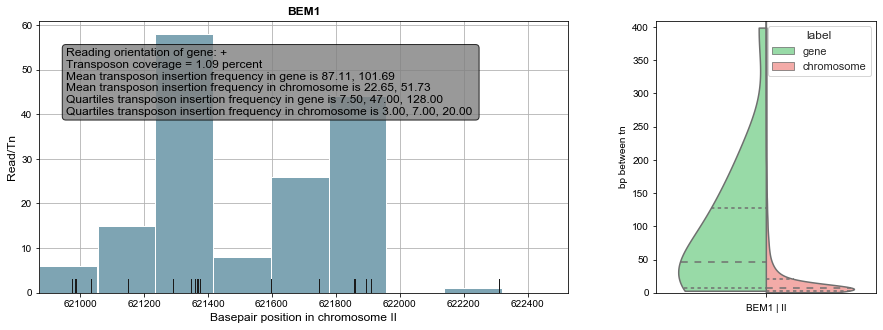

In [9]:
if gene_name != None:
    print('Plotting reads for gene ', gene_name, '...')
else:
    print('Plotting reads in range ', gene_start, '..', gene_end, 'in chromosome ', gene_chr, '...')

text_size = 12

plt.figure(figsize=(15,5))#(figsize=(19,9))
grid = plt.GridSpec(1, 3, wspace=0.4, hspace=0.3)

ax = plt.subplot(grid[0,:2])
ax.bar(insertion_roi_binnedlist,reads_roi_binnedlist,width=bin_width,facecolor=np.array([126.0,164.0,179.0])/255,edgecolor='w')
ax.set_axisbelow(True)
ax.grid(True)
if gene_name != None:
    ax.set_title(gene_name, fontweight='bold', fontsize=text_size)
elif region == ['IV',46271,48031]:
    ax.set_title('HO-locus', fontweight='bold', fontsize=text_size)
else:
    ax.set_title(str(gene_chr) + str(gene_start) + '-' + str(gene_end))
ax.set_xlabel('Basepair position in chromosome '+ gene_chr, fontsize=text_size) 
ax.set_ylabel('Read/Tn', fontsize=text_size)
ax.set_xlim(gene_start,gene_end)

if gene_name != None and gene_name != 'HOlocus':
    if insertion_list != []:
        textstr = '\n'.join((r'Reading orientation of gene: ' + gene_orien,
                            r'Transposon coverage = %.2f percent' % (coverage_percentage),
                            r'Mean transposon insertion frequency in gene is %.2f, %.2f ' % (insertion_avgperiodicity, insertion_stdperiodicity),
                            r'Mean transposon insertion frequency in chromosome is %.2f, %.2f' % (insertion_chromosome_avgperiodicity, insertion_chromosome_stdperiodicity),
                            r'Quartiles transposon insertion frequency in gene is %.2f, %.2f, %.2f ' % (insertion_firstquartileperiodicity, insertion_medperiodicity, insertion_thirdquartileperiodicity),
                            r'Quartiles transposon insertion frequency in chromosome is %.2f, %.2f, %.2f ' % (insertion_chromosome_firstquartileperiodicity, insertion_chromosome_medperiodicity, insertion_chromosome_thirdquartileperiodicity)
                            ))
    else:
        textstr = (r'Reading orientation of gene: ' + gene_orien)
else:
    textstr = '\n'.join((r'Transposon coverage = %.2f percent' % (coverage_percentage),
                        r'Mean transposon insertion frequency in gene is %.2f, %.2f ' % (insertion_avgperiodicity, insertion_stdperiodicity),
                        r'Mean transposon insertion frequency in chromosome is %.2f, %.2f' % (insertion_chromosome_avgperiodicity, insertion_chromosome_stdperiodicity),
                        r'Quartiles transposon insertion frequency in gene is %.2f, %.2f, %.2f ' % (insertion_firstquartileperiodicity, insertion_medperiodicity, insertion_thirdquartileperiodicity),
                        r'Quartiles transposon insertion frequency in chromosome is %.2f, %.2f, %.2f ' % (insertion_chromosome_firstquartileperiodicity, insertion_chromosome_medperiodicity, insertion_chromosome_thirdquartileperiodicity)
                        ))
props = dict(boxstyle='round', facecolor='grey', alpha=0.8)
ax.text(0.05,0.9, textstr, transform=ax.transAxes, fontsize=text_size,
    verticalalignment='top',horizontalalignment='left', bbox=props)

for ins in insertion_list: #PLOT TICKS ON THE X AXIS TO INDICATE THE EXACT INSERTION LOCATIONS
    ax.axvline(x=ins, ymax=0.05, linewidth=1, color='k')



# COMPARE DISTRIBUTION OF BASEPAIRS BETWEEN INSERTIONS FOR THE CHROMOSOME AND THE GENE USING VIOLINPLOT
plt.subplot(grid[0,2])

if gene_name == None:
    if region == ['IV',46271,48031]:
        gene_name = 'HOlocus'
    else:
        gene_name = str(gene_chr) + str(gene_start) + '-' + str(gene_end)

bp_between_tn_insertions_dict = {}
bp_between_tn_insertions_dict[gene_chr] = bp_between_tn_insertions

df_chr = pd.DataFrame(bp_between_tn_insertions_chr_dict)
df = pd.DataFrame(bp_between_tn_insertions_dict)
if len(df) !=0:
    df_concat = pd.concat([df,df_chr], axis=0, ignore_index=True)
    names_list = ['gene']*len(bp_between_tn_insertions) + ['chromosome']*len(bp_between_tn_insertions_chr_dict.get(gene_chr))
    df_concat['label'] = names_list
    xlabel=gene_name+' | '+gene_chr
    df_concat[xlabel] = ''
    df_concat.columns = ['bp between tn','label',xlabel]

    sb.set(style="whitegrid", palette="pastel", color_codes=True)
    sb.violinplot(data=df_concat,x=xlabel, y='bp between tn', hue='label', inner='quartile', scale='width', gridsize=5000, split=True, cut=0, palette={"gene": "g", "chromosome": "r"})
    plt.ylim(0,max_empty_region+10)
else:
    sb.violinplot(data=df_chr, inner='quartile', orien='v', scale='width', gridsize=5000, cut=0)

plt.show()
if savefigure == True:
    plt.savefig(os.path.join(save_figure_path, gene_name+'_TnInsertions.png'), dpi=300)
    print('Figure saved at ', save_figure_path)

## Interpretation
The resulting barplot shows the insertions (represented by the small black bars) along the gene. The blue bars indicate the number of reads per transposon in that bin. This shows how the insertions and reads are distributed along the gene.
The reading orientation is indicated by a + (forward reading) or - (reverse reading). The numbers for the mean are given together with the standard deviation (note that this is typically very large). Therefore a more reliable measure might be the percentiles given as the 25th, 50th and the 75th percentile respectively.

The violinplot shows the distribution of the amount of basepairs between subsequent insertions for both the gene (green) and the chromomsome the gene is in (red). A significant difference in the median basepairs between insertions might indicate potential essential genes.

## Bibliography
- Michel, A. H., Hatakeyama, R., Kimmig, P., Arter, M., Peter, M., Matos, J., ... & Kornmann, B. (2017). Functional mapping of yeast genomes by saturated transposition. Elife, 6, e23570.